# Vinamilk (VNM) STOCK PREDICTION

### **1. <span style='color:#E55807'>|</span> Import Necessary Library**

In [35]:
from vnstock3 import Vnstock
import mplfinance as mpf
import statsmodels.api as sm
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import plotly.express as px
import seaborn as sns 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Embedding, Bidirectional, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
import warnings
warnings.filterwarnings('ignore')
import plotly.io as pio
pio.renderers.default = "notebook_connected"


### **2. <span style='color:#E55807'>|</span> Exploratory Data Analysis**

In [8]:
company = Vnstock().stock(symbol='VNM', source='TCBS').company
company.overview()

,exchange,industry,company_type,no_shareholders,foreign_percent,outstanding_share,issue_share,established_year,no_employees,stock_rating,delta_in_week,delta_in_month,delta_in_year,short_name,website,industry_id,industry_id_v2
0,HOSE,Thực phẩm và đồ uống,CT,0,0.517,2090.0,2090.0,2003,10072,2.4,-0.02,-0.025,-0.147,VINAMILK,https://www.vinamilk.com.vn,218,3577


In [9]:
stock = Vnstock().stock(symbol='VNM', source='VCI')
df = stock.quote.history(start='2019-01-01', end='2024-11-22')
df.info()
df.head()

2024-12-04 13:36:35 - vnstock3.common.data.data_explorer - WARNING - Thông tin niêm yết & giao dịch sẽ được truy xuất từ TCBS


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1473 entries, 0 to 1472
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1473 non-null   datetime64[ns]
 1   open    1473 non-null   float64       
 2   high    1473 non-null   float64       
 3   low     1473 non-null   float64       
 4   close   1473 non-null   float64       
 5   volume  1473 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 69.2 KB


,time,open,high,low,close,volume
0,2019-01-02,78.08,79.69,77.76,79.69,403570
1,2019-01-03,79.69,79.69,78.15,78.98,449730
2,2019-01-04,78.72,80.33,77.76,80.33,498470
3,2019-01-07,82.07,84.19,80.65,84.19,897430
4,2019-01-08,84.44,84.44,82.71,83.54,448350


In [10]:
print(df.isnull().sum())

time      0
open      0
high      0
low       0
close     0
volume    0
dtype: int64


In [11]:
df.describe(include='all')

,time,open,high,low,close,volume
count,1473,1473.000000,1473.000000,1473.000000,1473.000000,1.473000e+03
mean,2021-12-14 14:21:15.763747328,73.870754,74.521704,73.213530,73.813327,2.345528e+06
min,2019-01-02 00:00:00,55.810000,57.870000,55.810000,55.810000,2.717300e+05
25%,2020-06-26 00:00:00,66.410000,67.000000,65.810000,66.290000,1.138300e+06
50%,2021-12-10 00:00:00,72.440000,73.200000,71.790000,72.360000,2.040145e+06
75%,2023-06-07 00:00:00,79.980000,80.630000,79.600000,80.050000,3.013500e+06
max,2024-11-22 00:00:00,96.810000,98.070000,95.900000,97.430000,2.116741e+07
std,NaN,8.699546,8.705796,8.639016,8.693214,1.701302e+06


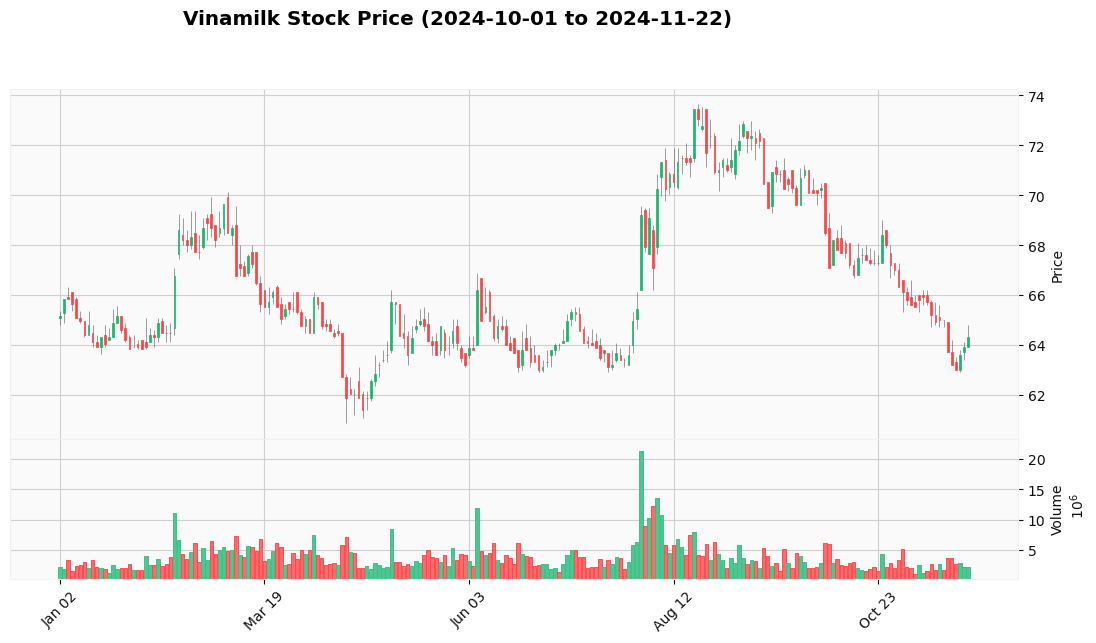

In [12]:
#Filter VNM stock historical data from 01/2024 - 11/2024
#Convert time column
df_analyze = df.copy()
df_analyze['time'] = pd.to_datetime(df_analyze['time'])

#Set time column as index
df_analyze.set_index('time', inplace=True)

#Filter to Plotting chart
filtered_df = df_analyze.loc['2024-01-01':'2024-11-22']

#Plotting the candlestick chart for historical data from 01/01/2024 - 22/11/2024
mpf.plot(filtered_df, type='candle', volume=True, style='yahoo', title='Vinamilk Stock Price (2024-10-01 to 2024-11-22)',
         ylabel='Price', ylabel_lower='Volume', figsize=(14, 7))

In [36]:
# Plot the closing price over time
fig = px.line(x= df_analyze.index, y= df_analyze['close'], title = 'Vinamilk Closing Price Over Time', labels ={"x":"Date", "y":"Closing Price"})
fig.update_layout(height=500, width=750, template="plotly_white", font_color="grey", font_size =12, title_font_color="black", title_font_size =24)
fig.show()

In [37]:
from plotly.subplots import make_subplots
# Dimensions for the scatterplot matrix
dimensions = ["open", "high", "low", "close", "volume"]

# Create a 5x5 subplot layout
fig = make_subplots(
    rows=len(dimensions), cols=len(dimensions),
    specs=[[{'type': 'scatter'}]*len(dimensions) for _ in range(len(dimensions))],
    subplot_titles=[f"{y} vs {x}" if x != y else f"{x}" for y in dimensions for x in dimensions]
)

# Loop through dimensions to populate the matrix
for i, x in enumerate(dimensions):  # Iterate over columns
    for j, y in enumerate(dimensions):  # Iterate over rows
        if i != j:
            # Off-diagonal: scatter plot
            fig.add_trace(go.Scatter(x=filtered_df[x], y=filtered_df[y], mode='markers', marker=dict(color='rgba(0, 100, 200, 0.7)'), showlegend=False), row=j + 1, col=i + 1)
        else:
            # Diagonal: histogram
            fig.add_trace(go.Histogram(x=filtered_df[x], marker=dict(color='rgba(200, 0, 100, 0.7)'), showlegend=False), row=j + 1, col=i + 1)

# Update layout settings
fig.update_layout(height=700, width=750, template="plotly_white", title='Relationship between open, high, low, close, and volume of VNM Stock',
    font_color="grey", font_size=12, title_font_color="black", title_font_size=24)

# Show the plot
fig.show()


### **3. <span style='color:#E55807'>|</span> Modeling (Bidirectional LSTM)**

#### **3.1 Preprocessing**

In [16]:
df_data = df[['time','open','close']]
df_data.set_index('time',drop=True,inplace=True)
df_data.reset_index(inplace=True)
df_data.info()
df_data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1473 entries, 0 to 1472
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1473 non-null   datetime64[ns]
 1   open    1473 non-null   float64       
 2   close   1473 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 34.7 KB


,time,open,close
0,2019-01-02,78.08,79.69
1,2019-01-03,79.69,78.98
2,2019-01-04,78.72,80.33
3,2019-01-07,82.07,84.19
4,2019-01-08,84.44,83.54
5,2019-01-09,83.54,84.77
6,2019-01-10,84.77,84.64
7,2019-01-11,84.64,86.11
8,2019-01-14,85.47,86.76
9,2019-01-15,86.76,86.69


In [17]:
# Normalization Data
scaler = MinMaxScaler()
numerical_columns = ['open', 'close']
df_data[numerical_columns] = scaler.fit_transform(df_data[numerical_columns])

In [18]:
# Split Train - Test data
training_size = round(len(df_data) * 0.80)
train_data = df_data[:training_size]
test_data  = df_data[training_size:]

train_data.set_index('time',inplace=True)
test_data.set_index('time',inplace=True)

display(train_data.head())
display(test_data.tail())
display(test_data.shape, train_data.shape)

,open,close
time,,
2019-01-02,0.543171,0.573763
2019-01-03,0.582439,0.556704
2019-01-04,0.558780,0.589140
2019-01-07,0.640488,0.681884
2019-01-08,0.698293,0.666266


,open,close
time,,
2024-11-18,0.192439,0.177559
2024-11-19,0.182683,0.172753
2024-11-20,0.175366,0.187170
2024-11-21,0.192439,0.194378
2024-11-22,0.197317,0.203988


(295, 2)

(1178, 2)

In [19]:
def create_sequence(dataset):
  sequences = []
  labels = []
  start_idx = 0
  for stop_idx in range(50,len(dataset)):
    sequences.append(dataset.iloc[start_idx:stop_idx])
    labels.append(dataset.iloc[stop_idx])
    start_idx += 1
  return (np.array(sequences),np.array(labels))

train_seq, train_label = create_sequence(train_data)
test_seq, test_label = create_sequence(test_data)

display(train_seq.shape, test_seq.shape)

(1128, 50, 2)

(245, 50, 2)

#### **3.2 Define Bidirectional LSTM**

In [20]:
def build_BiLSTM_model():
    input = tf.keras.layers.Input(
        shape=(train_seq.shape[1], train_seq.shape[2]), name ="input"
    )
    x = tf.keras.layers.Bidirectional(LSTM(512, return_sequences=True))(input)

    x = tf.keras.layers.Bidirectional(LSTM(316, return_sequences=False, dropout=0.5))(x)

    x = tf.keras.layers.Dense(128 , activation="relu", name ="dense_1")(x)

    output = tf.keras.layers.Dense(2, name="last_dense")(x)

    model = tf.keras.Model(inputs=input, outputs=output)
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

    return model

LSTM_model = build_BiLSTM_model()
LSTM_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 50, 2)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 50, 1024)       │     2,109,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 632)            │     3,390,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        81,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last_dense (Dense)              │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,580,770 (21.29 MB)

 Trainable params: 5,580,770 (21.29 MB)

 Non-trainable params: 0 (0.00 B)

#### **3.3 Training Data**

In [21]:
batch_size = 20
early_stopping_patience = 17
LSTM_model.fit(train_seq, train_label, epochs=80,validation_data=(test_seq, test_label), verbose=1)

Epoch 1/80
36/36 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - loss: 0.0847 - mean_absolute_error: 0.1927 - val_loss: 0.0016 - val_mean_absolute_error: 0.0310
Epoch 2/80
36/36 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - loss: 0.0038 - mean_absolute_error: 0.0472 - val_loss: 8.6478e-04 - val_mean_absolute_error: 0.0230
Epoch 3/80
36/36 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - loss: 0.0024 - mean_absolute_error: 0.0376 - val_loss: 0.0014 - val_mean_absolute_error: 0.0329
Epoch 4/80
36/36 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - loss: 0.0028 - mean_absolute_error: 0.0409 - val_loss: 6.1850e-04 - val_mean_absolute_error: 0.0180
Epoch 5/80
36/36 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - loss: 0.0020 - mean_absolute_error: 0.0337 - val_loss: 5.6969e-04 - val_mean_absolute_error: 0.0177
Epoch 6/80
36/36 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - loss: 0.0021 - mean_absolute_error: 0.0341 - val_loss: 6.1665e-04 - val_mean_absolute_error: 0.0195
Epoch 7/80
36/36 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - loss: 0.0018 - mean_absolute_error: 0.0327 -

#### **3.4 Evaluate Model**

In [22]:
test_predicted = LSTM_model.predict(test_seq)
test_inverse_predicted = scaler.inverse_transform(test_predicted)

test_inverse_predicted[:5]

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 360ms/step


array([[64.873665, 64.69259 ],
       [64.00423 , 63.799187],
       [64.67144 , 64.51376 ],
       [65.164474, 65.034805],
       [64.67219 , 64.50622 ]], dtype=float32)

In [23]:
df_slice_data = pd.concat([df_data .iloc[-245:].copy(),pd.DataFrame(test_inverse_predicted,columns=['open_predicted','close_predicted'],index=df_data .iloc[-245:].index)], axis=1)
df_slice_data[['open','close']] = scaler.inverse_transform(df_slice_data[['open','close']])
display(df_slice_data.head())
df_slice_data.info()

,time,open,close,open_predicted,close_predicted
1228,2023-11-30,64.77,63.83,64.873665,64.692589
1229,2023-12-01,64.39,64.77,64.004227,63.799187
1230,2023-12-04,64.87,65.15,64.671440,64.513763
1231,2023-12-05,65.15,64.49,65.164474,65.034805
1232,2023-12-06,64.49,64.87,64.672188,64.506218


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245 entries, 1228 to 1472
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   time             245 non-null    datetime64[ns]
 1   open             245 non-null    float64       
 2   close            245 non-null    float64       
 3   open_predicted   245 non-null    float32       
 4   close_predicted  245 non-null    float32       
dtypes: datetime64[ns](1), float32(2), float64(2)
memory usage: 7.8 KB


In [24]:
df_slice_data['time'] = pd.to_datetime(df_slice_data['time'])

#Set time column as index
df_slice_data.set_index('time', inplace=True)
df_slice_data

,open,close,open_predicted,close_predicted
time,,,,
2023-11-30,64.77,63.83,64.873665,64.692589
2023-12-01,64.39,64.77,64.004227,63.799187
2023-12-04,64.87,65.15,64.671440,64.513763
2023-12-05,65.15,64.49,65.164474,65.034805
2023-12-06,64.49,64.87,64.672188,64.506218
...,...,...,...,...
2024-11-18,63.70,63.20,63.959431,63.757103
2024-11-19,63.30,63.00,63.396782,63.193104
2024-11-20,63.00,63.60,63.143879,62.945084


In [40]:
# Plot Actual vs Predicted for open price
fig = go.Figure(data=go.Scatter(x= df_slice_data.index, y= df_slice_data['open'], mode='lines', marker_color ="royalblue", name='Actual Open Value'))
fig.add_trace(go.Scatter(x=df_slice_data.index, y=df_slice_data['open_predicted'], mode='lines', marker_color ="darkorange", name='Predicted Open Value'))

fig.update_xaxes(title_text ="Date")
fig.update_yaxes(title_text ="Stock Price")
fig.update_layout(height=500, width=750, template="plotly_white", title = 'Actual vs Predicted for open price',
        font_color="grey", font_size =12,
        title_font_color="black", title_font_size =24)
fig.show()

In [39]:
# Plot Actual vs Predicted for close price
fig = go.Figure(data=go.Scatter(x= df_slice_data.index, y= df_slice_data['close'], mode='lines', marker_color ="royalblue", name='Actual close price'))
fig.add_trace(go.Scatter(x=df_slice_data.index, y=df_slice_data['close_predicted'], mode='lines', marker_color ="darkorange", name='Predicted close price'))

fig.update_xaxes(title_text ="Date")
fig.update_yaxes(title_text ="Stock Price")
fig.update_layout(height=500, width=750, template="plotly_white", title = 'Actual vs Predicted for close price',
        font_color="grey", font_size =12,
        title_font_color="black", title_font_size =24,
        legend_title=None, legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='center', x=0.5))
fig.show()

### **4. <span style='color:#E55807'>|</span> Further Prediction (using Bidirectional LSTM)**

In [27]:
# Convert NumPy array to DataFrame
df_data = pd.DataFrame(df_data, columns=['open', 'close'])

# Keep rows from index 0 to 1472
df_data = df_data.iloc[:1473]  

# Reset index
df_data.reset_index(drop=True, inplace=True)
# Create a date range for the next 180 business days
last_date = df['time'].iloc[-1]
business_days = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=180, freq='B')

predictions = []

# Loop through the business days
for next_date in business_days:
    # Get the last 50 rows of 'open' and 'close' prices for prediction
    last_50_data = df_data[-50:]  # Get the last 50 normalized rows

    # Reshape the data for LSTM input
    x_next = np.array([last_50_data])  # Shape will be (1, 50, 2)
    x_next = np.reshape(x_next, (x_next.shape[0], x_next.shape[1], 2))  # Ensure shape is (1, 50, 2)

    # Make predictions using the trained LSTM model
    y_next_predict = LSTM_model.predict(x_next)

    # Inverse transform the predicted values to get actual prices
    y_next_predict_inverse = scaler.inverse_transform(y_next_predict)

    # Prepare the DataFrame for the next day's prediction
    df_next = pd.DataFrame({
        'time': [next_date], 
        'open_predicted': [y_next_predict_inverse[0][0]], 
        'close_predicted': [y_next_predict_inverse[0][1]]
    })

    # Append the prediction to the predictions list
    predictions.append(df_next)

    # Normalize the predicted values before appending to df_data
    new_row_normalized = scaler.transform(np.array([[y_next_predict_inverse[0][0], y_next_predict_inverse[0][1]]]))

    # Append the new normalized predicted row to the normalized DataFrame
    new_row = pd.DataFrame(new_row_normalized, columns=['open', 'close'])
    df_data = pd.concat([df_data, new_row], ignore_index=True)  # Append the new predicted row to the DataFrame

# Combine all predictions into a single DataFrame
df_predictions = pd.concat(predictions, ignore_index=True)

df_slice_col=df_slice_data.reset_index()
final_df = pd.concat([df_slice_col, df_predictions], ignore_index=True)
print(final_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━

In [43]:
file_name = 'VNM 6 months prediction.xlsx'

# saving the excel
final_df.to_excel(file_name)

In [42]:
print(df_predictions.head(15))

         time  open_predicted  close_predicted
0  2024-11-25       64.396118        64.245888
1  2024-11-26       64.347000        64.185394
2  2024-11-27       64.280724        64.114395
3  2024-11-28       64.221153        64.053589
4  2024-11-29       64.181702        64.013023
5  2024-12-02       64.163872        63.993649
6  2024-12-03       64.160667        63.988586
7  2024-12-04       64.162994        63.989716
8  2024-12-05       64.165321        63.992329
9  2024-12-06       64.162216        63.992214
10 2024-12-09       64.153114        63.988899
11 2024-12-10       64.140511        63.984440
12 2024-12-11       64.126968        63.980957
13 2024-12-12       64.116875        63.981350
14 2024-12-13       64.113014        63.985970


In [38]:
# Plotting the predicted open data until 7/2025
fig1 = go.Figure(data=go.Scatter(x= final_df['time'], y= final_df['open'], mode='lines', marker_color ="red", name='Actual Open Price'))
fig1.add_trace(go.Scatter(x=final_df['time'], y=final_df['open_predicted'],line = dict(color='blue',dash='dash'),
                         marker_color ="blue", name='Predicted Open Price'))

fig1.update_xaxes(title_text ="Date")
fig1.update_yaxes(title_text ="Stock Price")
fig1.update_layout(height=500,width=800, template="plotly_white", title = 'Vinamilk Stock Open Price Prediction for the next 6 months',
        font_color="grey", font_size =12,
        title_font_color="black", title_font_size =24)
fig1.show()

# Plotting the predicted close data until 7/2025
fig2 = go.Figure(data=go.Scatter(x= final_df['time'], y= final_df['close'], mode='lines', marker_color ="red", name='Actual Close Price'))
fig2.add_trace(go.Scatter(x=final_df['time'], y=final_df['close_predicted'],line = dict(color='blue',dash='dash'),
                         marker_color ="blue", name='Predicted Close Price'))

fig2.update_xaxes(title_text ="Date")
fig2.update_yaxes(title_text ="Stock Price")
fig2.update_layout(height=500, width=800, template="plotly_white", title = 'Vinamilk Stock Close Price Prediction for the next 6 months',
        font_color="grey", font_size =12,
        title_font_color="black", title_font_size =24,
        legend_title=None, legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='center', x=0.5))
fig2.show()